## Analyze model predictions from latent code using PCA, tSNE, and UMAP
---
*Last edited 23 Oct 2025 by K. Wolcott*

In [1]:
# Read in data from latent codes for training attempt
import os, re, json, torch, numpy as np, pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Specify training directory that contains config.json, latent_codes/, and model/
train_dir = 'run_v30' # TO DO: Update to relevant training attempt directory
os.chdir(train_dir)

# Specify model ckpt to use
CKPT = '3000' # TO DO: Choose the ckpt value you want to analyze results for

# Load config
config_path = 'model_params_config.json'
try:
    with open(config_path, 'r') as f:
        cfg = json.load(f)
    print(f"\033[92mLoaded config from {config_path}\033[0m")
except FileNotFoundError:
    print(f"\033[31mError: model_params_config.json not found in {config_path}. Exiting.\033[0m")

# Get training paths from config
train_paths = cfg['list_mesh_paths']
all_vtk_files = [os.path.basename(f) for f in train_paths]

# Parse species and vertebra info from filenames (e.g. "H-capensis-22-L8.ply_align.vtk").
pat = re.compile(r"^(?P<species>[\w\s\-]+)[\-_ ]+\d+[\-_ ]+(?P<vertebra>[CTL]\d+)", re.IGNORECASE)
labels = []
unmatched_files = []
for f in all_vtk_files:
    fname = os.path.basename(f)
    m = pat.match(fname)
    if m:
        species = m.group("species").strip()
        vertebra = m.group("vertebra").strip()  # e.g. "C2", "L8"
        labels.append((species, vertebra))
    else:
        labels.append((None, None))
        unmatched_files.append(fname)

# Load latent codes from the single .pth file.
CKPT_PATH = 'latent_codes' + '/' + CKPT + '.pth'
latent_ckpt = torch.load(CKPT_PATH, map_location="cpu") 
codes = latent_ckpt['latent_codes']['weight'].detach().cpu().numpy()

Loaded config from model_params_config.json


/tmp/ipykernel_822324/1303964133.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_ckpt = torch.load(CKPT_PATH, map_location="cpu")


## Statistical analysis of model performance - PCA, tSNE, UMAP
---

In [2]:
# Define functions for plotting
import colorsys
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import shuffle
from itertools import combinations
from statsmodels.multivariate.manova import MANOVA

# Get marker based on life history of species
def get_marker(species):
    species = species.lower()
    if "ouroborus" in species:  # bites tail to front
        return 'v' # triangle (down)
    elif any(k in species for k in ["chalcides", "tetradactylus", "chamaesaura"]):  # swims in grass
        return 'P' # plus filled
    elif any(k in species for k in ["skoog", "eremiascincus", "_scincus"]): # swims in sand
        return '+'  # plus regular
    elif any(k in species for k in ["acontias", "mochlus", "rhineura", "dibamus", "lanthonotus", "bipes", "diplometopon", "pseudopus"]):  # burrowing
        return 's'  # square
    elif any(k in species for k in ["jonesi", "corucia", "gecko", "chamaeleo", "iguana", "brookesia", "dracaena", "anolis", "basiliscus", 
                                    "dracaena", "aristelliger", "sceloporus", "lialis", "phyllurus"]):  # arboreal
        return 'd' # thin diamond
    elif any(k in species for k in ["elgaria", "smaug_giganteus", "broadleysaurus", "ateuchosaurus", "alopoglossus", "heloderma", "tupinambis",
                                    "carlia", "lipinia", "tiliqua", "tribolonotus", "leiolepis", "eublepharis", "oreosaurus", "baranus",
                                    "callopistes", "cricosaura", "lepidophyma", "sphenodon", "lacerta", "enyaloides", "crocodilurus"]):  # terrestrial
        return 'X' # x filled
    elif any(k in species for k in ["eryx", "homalopsis", "aniolios"]):   # snake
        return '2' #
    else:                      # saxicolous/rock dwelling
        return 'o'  # circle (default)
    
# Make a reference legend for marker symbols
# Define markers and their corresponding life history strategy labels
legend_items = [
    ('v', 'Bites tail to side'),
    ('P', 'Grass swimmer'),
    ('+', 'Sand swimmer'),
    ('s', 'Burrowers'),
    ('d', 'Arboreal'),
    ('X', 'Terrestrial'),
    ('o', 'Saxicolous'),
    ('2', 'Snake')
]

# Get family name for coloring scheme
def extract_family(species_label):
    family = species_label.split('_')[0]
    species_label = species_label.lower()
    
    if any(k in species_label for k in ["scincus", "scincidae"]):
        family = "Scincidae"
    elif "ouroborus" in species_label:
        family = "Cordylidae_Ouroborus"
    elif any(k in species_label for k in ["gerrhosaurus", "gerrho"]):
        family = "Gerrhosauridae"
    elif any(k in species_label for k in ["chameleo", "iguana", "agamidae", "anolidae", "corytophanidae", 
                                          "crotaphytidae", "hoplocercidae", "leiocephalidae", "leiosauridae",
                                          "phrynosomatidae", "tropiduridae"]):
        family = "Iguania"
    elif any(k in species_label for k in ["anguidae", "lanthonotus", "varanus", "shinosaurus", "heloderma"]):
        family = "Anguimorpha"
    elif any(k in species_label for k in  ["lacertidae", "lacerta"]):
        family = "Lacertidae" 
    elif any(k in species_label for k in  ["bipes", "rhineura", "diplometopon"]):
        family = "Amphisbaenea"
    elif any(k in species_label for k in  ["gecko", "tarentola", "eublepharis", "aristelliger", "phyllurus", "lialis"]):
        family = "Gekkota"    
    elif any(k in species_label for k in ["eryx", "homalopsis", "aniolios"]):
        family = "Snake"
    elif "xantusiidae" in species_label:
        family = "Xantusiidae"
    elif any(k in species_label for k in ["gymnopthalmidae", "teiidae"]):
        family = "Gymnophthalmoidea"
    elif "dibamus" in species_label:
        family = "Dibamidae"
    elif "sphenodon" in species_label:
        family = "Rhynchocephalia"
    
    return family

# Workaround for seaborn kde plot level alpha channels to ensure colors go from more to less opaque without any grey
def get_gradient_cmap(color, n=256, white_level=0.8):
    r, g, b = color
    light_color = (
        r + (1 - r) * white_level,
        g + (1 - g) * white_level,
        b + (1 - b) * white_level,
    )
    colors = [light_color, (r, g, b)]
    return LinearSegmentedColormap.from_list("gradient_cmap", colors, N=n)

# Cross validate LDA predictions
def lda_permutation_test(X, y, model, n_permutations=1000, cv=5):
    real_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
    real_mean = real_scores.mean()
    
    permuted_scores = []
    for _ in range(n_permutations):
        y_perm = shuffle(y, random_state=None)
        score = cross_val_score(model, X, y_perm, cv=cv, scoring='balanced_accuracy').mean()
        permuted_scores.append(score)

    p_value = np.mean([score >= real_mean for score in permuted_scores])
    return real_mean, permuted_scores, p_value

# Define a color map for different life history strategies (marker types)
markers = ['v', 'P', '+', 's', 'd', 'X', 'o', '2']
colors =    [(0.32, 0.24, 0.56),  # russian violet
            (0.65, 0.69, 0.12),  # pea soup 
            (0.84, 0.65, 0.23),  # saffron
            #(0.78, 0.16, 0.16), # auburn
            (0.72, 0.44, 0.22), # mud
            (0.36, 0.557, 0.68),  # powder blue
            (0.10, 0.51, 0.40),  # deft blue
            #(0.98, 0.39, 0.14),  # fulvous 
            (0.60, 0.50, 0.46),  # slate
            (0,0,0) # 
            ]   
marker_to_color = dict(zip(markers, colors))

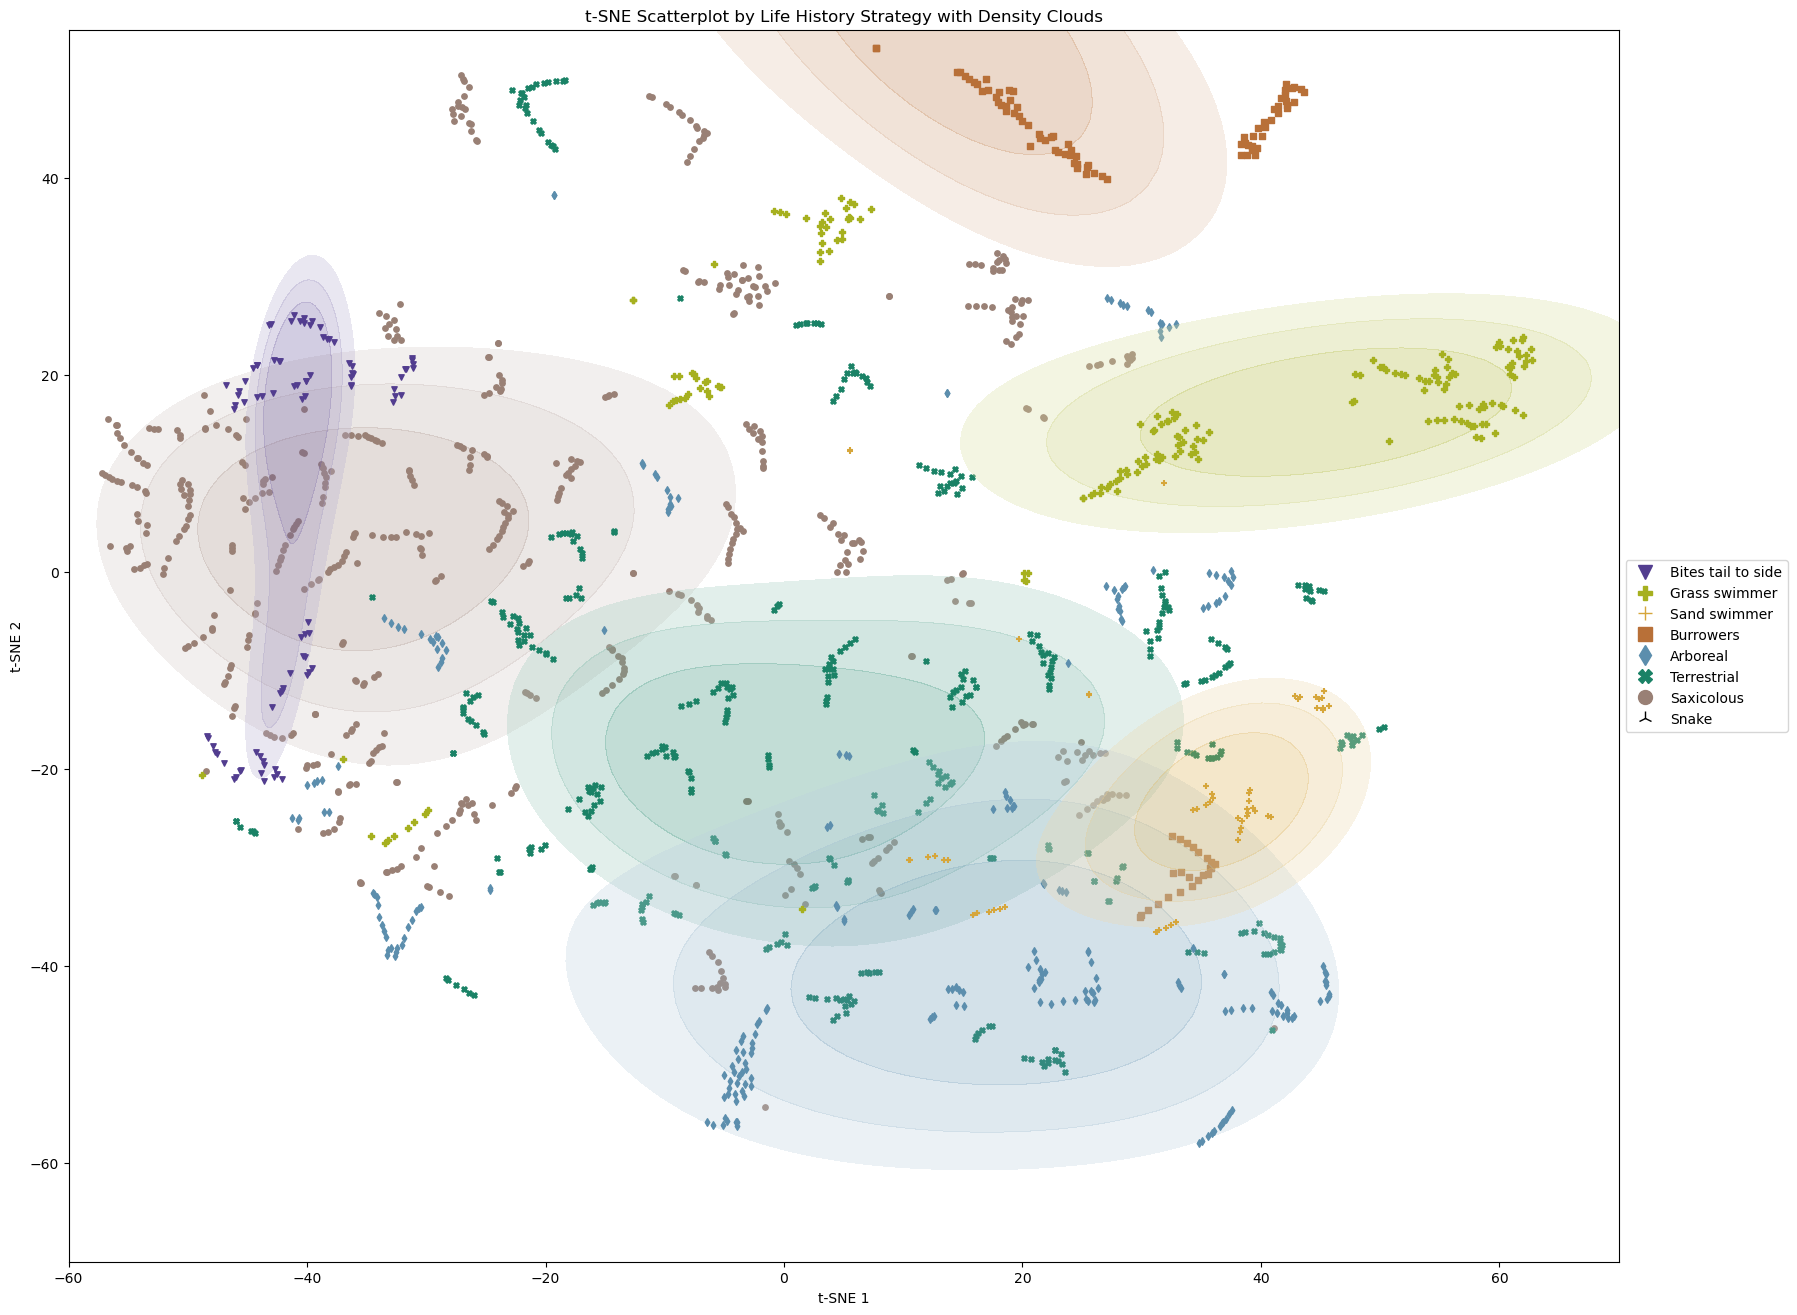

In [3]:
# Try with tSNE

# Run t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_coords = tsne.fit_transform(codes)

# Group tSNE results by strategy (life history strategy)
strategy_groups_tsne = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        strategy = get_marker(species)
        strategy_groups_tsne[strategy].append((vertebra, tsne_coords[i, 0], tsne_coords[i, 1]))

# Plot tSNE with KDE plots
plt.figure(figsize=(20,16))
plt.xlim(-60, 70)
plt.ylim(-70, 55)

for strategy, points in strategy_groups_tsne.items():
    points_sorted = sorted(points, key=lambda x: (x[0], x[1]))  # Sort by vertebra label if needed
    vertebra_labels, tsne1_vals, tsne2_vals = zip(*points_sorted)
    
    # Generate custom color palette for kdeplot (default uses grey to white shades of each color)
    cmap = get_gradient_cmap(marker_to_color[strategy], white_level=0.7)
    
    # Plot density cloud for each strategy (life history strategy marker)
    #if strategy == 'o' or strategy == 'X':  # Skip the Saxicolous/Default ('o') and Terrestrial ('X') strategies
        #plt.scatter(tsne1_vals, tsne2_vals, marker=strategy, color=marker_to_color[strategy], label=strategy, s=50)
        #continue
    sns.kdeplot(x=tsne1_vals, y=tsne2_vals, fill=True, cmap=cmap, alpha=0.3, bw_adjust=1.9, cut=5.0, thresh=0.7, levels=4)

    # Scatter plot the points with their corresponding marker
    plt.scatter(tsne1_vals, tsne2_vals, marker=strategy, color=marker_to_color[strategy], label=strategy, s=15)

# Customize labels and title
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("t-SNE Scatterplot by Life History Strategy with Density Clouds")

# Customize the legend using the provided legend items
handles = [plt.Line2D([0], [0], marker=marker, linestyle="None", markerfacecolor=marker_to_color[marker], markeredgecolor=marker_to_color[marker], markersize=10) for marker, _ in legend_items]
llabels = [label for _, label in legend_items]

# Display the customized legend
plt.legend(handles=handles, labels=llabels, loc='center left', bbox_to_anchor=(1, 0.5))
outfpath = os.path.split(os.getcwd())[1] + '_tsne_with_density_and_strategy_colors.png'
plt.savefig(outfpath, dpi=300, bbox_inches='tight')
plt.show()

Explained variance per LDA component: [0.41085232 0.18851897 0.14301906 0.10764663 0.07825534 0.07170768]


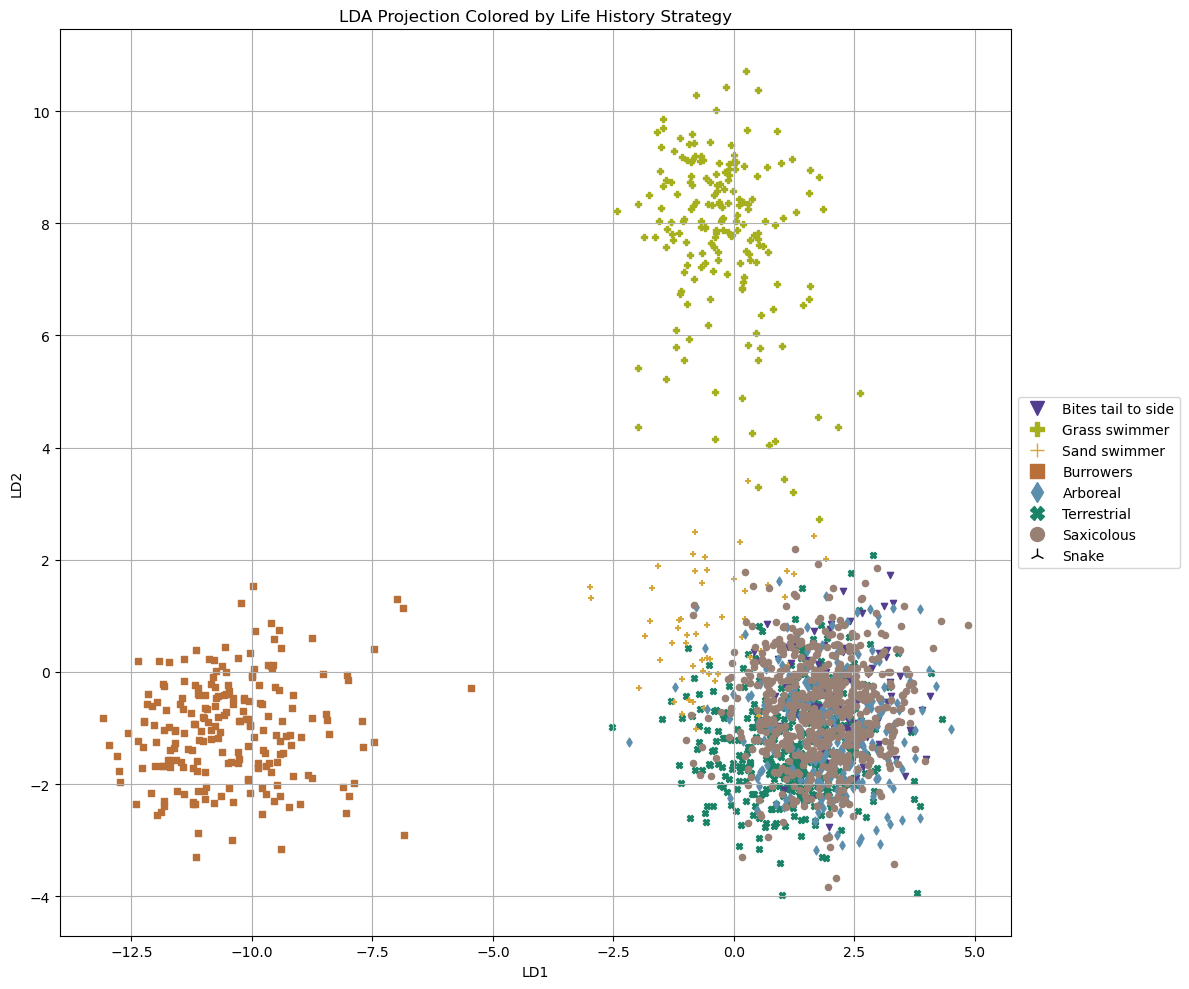

LDA Cross-Validation Accuracy: 0.57 ± 0.06


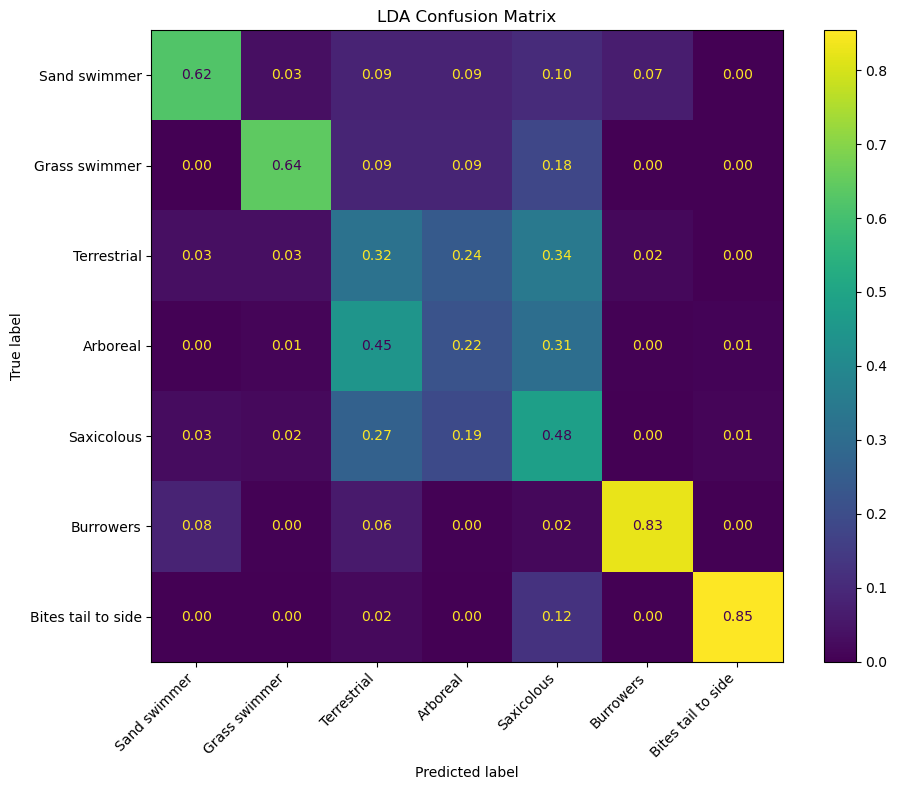

Real Accuracy: 0.566, Permutation p-value: 0.0000


In [5]:
# Use LDA on PCA of latent codes to see if groups identified from tSNE KDE are meaningful

# Filter out entries where species or vertebra is None
filtered_data = [(label, code) for label, code in zip(labels, codes) if label[0] is not None and label[1] is not None]

# Unpack filtered labels and codes
filtered_labels, filtered_codes = zip(*filtered_data)

# Now create your y with valid markers
y = [get_marker(species) for species, vertebra in filtered_labels]
scaler = StandardScaler()
filtered_codes_scaled = scaler.fit_transform(filtered_codes)
pca = PCA(n_components=0.99)
pca_all_codes = pca.fit_transform(filtered_codes_scaled)
X = pca_all_codes

# Fit LDA
lda = LDA(n_components=None)  # 2D for easy plotting
X_lda = lda.fit_transform(X, y)

# Check explained variance ratio
explained_variance = lda.explained_variance_ratio_
print("Explained variance per LDA component:", explained_variance)

# Plot LDA project
plt.figure(figsize=(12, 10))
for marker in set(y):
    idx = [i for i, val in enumerate(y) if val == marker]
    plt.scatter(X_lda[idx, 0], X_lda[idx, 1], 
                label=marker, marker=marker, color=marker_to_color[marker], s=20)

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Projection Colored by Life History Strategy")

# Customize the legend using the provided legend items
handles = [plt.Line2D([0], [0], marker=marker, linestyle="None", markerfacecolor=marker_to_color[marker], markeredgecolor=marker_to_color[marker], markersize=10) for marker, _ in legend_items]
llabels = [label for _, label in legend_items]
# Display the customized legend
plt.legend(handles=handles, labels=llabels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

scores = cross_val_score(lda, X, y, cv=5, scoring='balanced_accuracy')
print(f"LDA Cross-Validation Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

# Predict using cross-validation
y_pred = cross_val_predict(lda, X, y, cv=5)
# Confusion matrix
cm = confusion_matrix(y, y_pred, labels=lda.classes_, normalize='true')
# Custom labels
marker_to_label = dict(legend_items)
display_labels = [marker_to_label[cls] for cls in lda.classes_]
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='viridis', values_format='.2f', xticks_rotation=45, ax=ax)
# Set correct tick positions and labels explicitly - Hacky workaround bc long labels were getting shifted over by one column
n_labels = len(display_labels)
tick_positions = np.arange(n_labels)
ax.set_xticks(tick_positions)
ax.set_xticklabels(display_labels, rotation=45, ha='right')
ax.set_yticks(tick_positions)
ax.set_yticklabels(display_labels)

# Add title and layout adjustments
plt.title("LDA Confusion Matrix")
plt.tight_layout()
plt.show()

lda = LDA()
real_acc, perm_scores, p = lda_permutation_test(X, y, lda)
print(f"Real Accuracy: {real_acc:.3f}, Permutation p-value: {p:.4f}")

In [ ]:
# MANOVA
df = pd.DataFrame(X_lda, columns=[f"LD{i+1}" for i in range(X_lda.shape[1])])
df['group'] = y

manova = MANOVA.from_formula(' + '.join(df.columns[:-1]) + ' ~ group', data=df)
print(manova.mv_test())

# Prepare Dataframe
df = pd.DataFrame(X, columns=[f'X{i}' for i in range(X.shape[1])])
df['group'] = y

# Pairwise MANOVA tests
pairwise_results = []
unique_groups = sorted(set(y))
group_combos = list(combinations(unique_groups, 2))

for g1, g2 in group_combos:
    df_pair = df[df['group'].isin([g1, g2])]
    formula = ' + '.join(df.columns[:-1])  # all X features
    model = MANOVA.from_formula(f'{formula} ~ group', data=df_pair)
    test_res = model.mv_test()
    
    stats_df = test_res.results['group']['stat']
    wilks_lambda = stats_df.loc["Wilks' lambda", 'Value']
    p_value = stats_df.loc["Wilks' lambda", 'Pr > F']
    
    pairwise_results.append({
        'Group 1': g1,
        'Group 2': g2,
        'Wilks\' lambda': wilks_lambda,
        'p-value': p_value
    })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df.sort_values('p-value', inplace=True)
print(pairwise_df.head(10))  # Show top pairwise significant differences

                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
           Intercept        Value  Num DF   Den DF  F Value  Pr > F
-------------------------------------------------------------------
              Wilks' lambda 0.2603 6.0000 1802.0000 853.6532 0.0000
             Pillai's trace 0.7397 6.0000 1802.0000 853.6532 0.0000
     Hotelling-Lawley trace 2.8424 6.0000 1802.0000 853.6532 0.0000
        Roy's greatest root 2.8424 6.0000 1802.0000 853.6532 0.0000
-------------------------------------------------------------------
                                                                   
-------------------------------------------------------------------
         group           Value   Num DF   Den DF    F Value  Pr > F
-------------------------------------------------------------------
          Wilks' lambda  0.0000 36.0000  7915.8971 2675.3083 0.0000
 